# Fast Gradient Sign Attack

This notebook implements Fast Gradient Sign Attack.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

## Model Under Attack

Now, we want to get our model under attack. Let's use a pretrained ResNet on the ImageNet Dataset.

In [2]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

model = models.resnet18(True).to(device)

CUDA Available:  True


Now, we'll get our data from Imagenette.

In [3]:
def load_dataset(data_type):
    data_path = 'imagenette/' + data_type + '/'
    val_dataset = datasets.ImageFolder(
        root=data_path,
        transform=transforms.ToTensor()
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=1,
        num_workers=0,
        shuffle=True
    )
    return val_loader

test_loader = load_dataset('val')
train_loader = load_dataset('train')

First we'll fine-tune the AlexNet so that it can analyze data from Imagenette rather than ImageNet.

In [4]:
num_classes = 10
batch_size = 4
num_epochs = 15
feature_extract = False

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
set_parameter_requires_grad(model, False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224

We have training code, but now we need to change the last layer of our architecture from an FC>10 to an FC10 since the Imagenette dataset only has 10 classes.

In [8]:
model = model.to(device)

params = model.parameters()
print('Params:')

for name,param in model.named_parameters():
    if param.requires_grad:
        print('\t',name)

optimizer_ft = optim.AdamW(params, lr=0.001)

Params:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight

In [9]:
criterion = nn.CrossEntropyLoss()

dataloader_dict = {x: train_loader for x in ['train', 'val']}
print(dataloader_dict)

model, hist = train_model(model, dataloader_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f51dc849e80>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f51dc849e80>}
Epoch 0/14
----------
train Loss: 2.3750 Acc: 0.1020
val Loss: 2.4861 Acc: 0.1009

Epoch 1/14
----------
train Loss: 2.2884 Acc: 0.1299
val Loss: 2.5787 Acc: 0.0910

Epoch 2/14
----------
train Loss: 2.1782 Acc: 0.2077
val Loss: 2.3205 Acc: 0.1463

Epoch 3/14
----------
train Loss: 1.8051 Acc: 0.3744
val Loss: 2.2996 Acc: 0.2193

Epoch 4/14
----------
train Loss: 1.5365 Acc: 0.4799
val Loss: 2.1773 Acc: 0.3346

Epoch 5/14
----------
train Loss: 1.3186 Acc: 0.5629
val Loss: 3.6389 Acc: 0.3132

Epoch 6/14
----------
train Loss: 1.1082 Acc: 0.6368
val Loss: 3.1169 Acc: 0.3797

Epoch 7/14
----------
train Loss: 0.9218 Acc: 0.7011
val Loss: 2.8658 Acc: 0.3823

Epoch 8/14
----------
train Loss: 0.7627 Acc: 0.7571
val Loss: 2.7358 Acc: 0.4126

Epoch 9/14
----------
train Loss: 0.6253 Acc: 0.7967
val Loss: 4.7137 Acc: 0.4078

Epoch 10/14
-------

## Running FGSM

Proceeding with method of attack.

In [10]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [11]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [14]:
epsilons = [0, .01, .02, .03, .04, .05, .06]

accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 1476 / 3925 = 0.37605095541401273
Epsilon: 0.01	Test Accuracy = 395 / 3925 = 0.10063694267515924
Epsilon: 0.02	Test Accuracy = 116 / 3925 = 0.029554140127388533
Epsilon: 0.03	Test Accuracy = 43 / 3925 = 0.010955414012738853
Epsilon: 0.04	Test Accuracy = 16 / 3925 = 0.004076433121019108
Epsilon: 0.05	Test Accuracy = 6 / 3925 = 0.0015286624203821656
Epsilon: 0.06	Test Accuracy = 3 / 3925 = 0.0007643312101910828


## Analysis

First let's analyze a plot of accuracy vs. our peturbing epsilon (i.e. the degree of noise applied to our image)

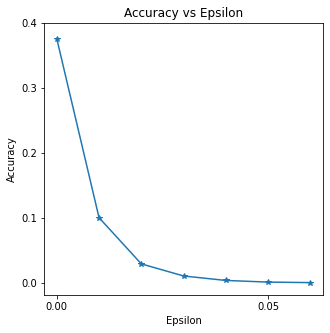

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.xticks(np.arange(0, .07, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

We can see that with an architecture such as ResNet, the accuracy drops heavily in the smallest increase of noise. The noise can be light to fool the neural network.